# Climate Analysis and Exploration

In [61]:
#Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine,inspect, func, desc
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
import datetime as dt

In [63]:
#Create engine for 'hawaii.sqlite' database
engine = create_engine("sqlite:///hawaii.sqlite")

#Declare a Base using `automap_base()`
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'stations']

In [64]:
#Save measurement and stations class as 'Measurement' and 'Stations' respectively
Measurement = Base.classes.measurement
Stations = Base.classes.stations

# Precipitation Analysis

In [65]:
#create session
session = Session(engine)

In [66]:
#Get dates from most recent to the last 12 months
most_current = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = most_current[0]
last_year = last_date.replace(year = (last_date.year - 1))
last_year = last_year.strftime("%Y-%m-%d")
last_year

'2016-08-23'

In [67]:
#query for precipitation data based on date range from most recent to a year before
one_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year)
#create data frame from sql query
one_year_prcp = pd.read_sql_query(one_year.statement, engine, index_col = 'date')
one_year_prcp.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


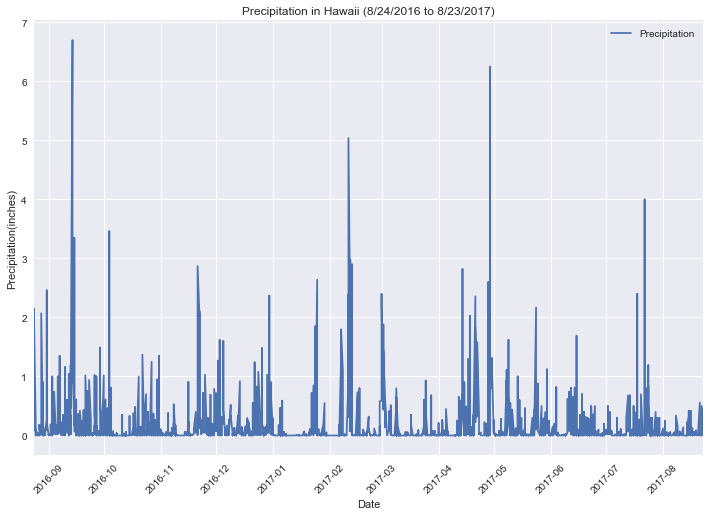

In [68]:
#Plot the dataframe to a horizontal bar chart
one_year_prcp.plot(figsize = (12,8), rot = 45, use_index = True)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation in Hawaii (8/24/2016 to 8/23/2017)")
plt.legend(["Precipitation"])
plt.show()

In [69]:
#Summary stats of the one year precipitation 
one_year_prcp.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [70]:
# Find the total number of stations
station_count = session.query(Stations.station).count()
station_count

9

In [71]:
# List the most active stations and their observation counts in descending order.
most_active = session.query(Stations.station, Stations.name, Measurement.station, func.count(Measurement.tobs)).filter(Stations.station == Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
most_active

[('USC00519281', 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 'USC00513117', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 'USC00519397', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2484),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 'USC00517948', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 342)]

In [72]:
#Most active station
max_activity = most_active[0][0:2]
print("The station with the highest number of observations is:", max_activity)


The station with the highest number of observations is: ('USC00519281', 'WAIHEE 837.5, HI US')


In [73]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
#Filter by the station with the highest number of observations.
max_ob = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == max_activity[0], Measurement.date > last_year).all()
len(max_ob)

351

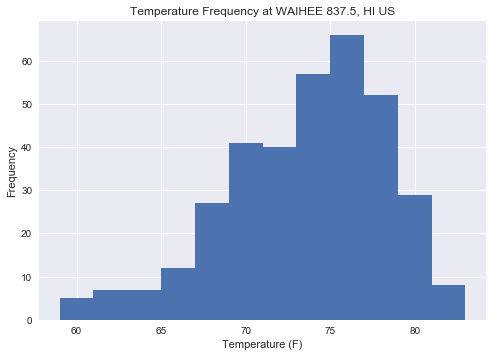

In [74]:
#Plot the results as a histogram with `bins=12`
temps = [x[1] for x in max_ob]
plt.hist(temps, bins=12)
plt.grid(True)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperature Frequency at %s" % (max_activity[1]))
plt.show()

# Temperature Analysis

In [77]:
#Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    #create dates 1 year prior
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    #query database for temps from those dates
    temp_values = session.query(Measurement.tobs).filter(Measurement.date >= new_dates[0], Measurement.date <= new_dates[1]).all()
    temp_values_list = [x for (x,) in temp_values]
    avg_temp = np.mean(temp_values_list)
    max_temp = max(temp_values_list)
    min_temp = min(temp_values_list)
    
    # create bar graph
    plt.figure(figsize=(3,6))
    plt.title("Trip Average Temperature")
    plt.ylabel("Temperature (F)")
    plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "", color="green")
    plt.show()

['2017-06-22', '2017-07-06']


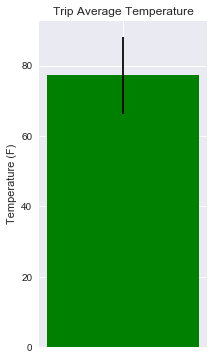

In [78]:
calc_temps('2018-06-22', '2018-07-06')